#### Read the raw text.

In [9]:
directory = 'brown'
filename = 'brown'
is_text_split_on_sentences = True
with open('corpora/{}/{}.txt'.format(directory, filename), 'r') as fd:
    text = fd.read()

#### Convert the raw text into sentences and tokens.

In [10]:
import re
# Remove punctuation, special characters.
# TODO: !!! Keep apostrophe (') when in the middle of a word.
text = re.sub('[\',-=;:"#+<>%$_()&*@^\[\]`~{}|\\\\]+', ' ', text)
# Create sentences, or boundaries for our context window.
if not is_text_split_on_sentences:
    text = re.sub('[.?!]+', '\n', text)
else:
    text = re.sub('[.?!]+', ' ', text)
sentences = text.split('\n')
# TODO: Do we have to convert all of the text to lowercase?
token_sentences = [[token.lower() for token in sentence.split()] for sentence in sentences]
print("Sentences: {}".format(len(token_sentences)))
token_count = len(token_sentences[0])
vocab = set(token_sentences[0])
for sentence in token_sentences[1:]:
    token_count += len(sentence)
    vocab.update(sentence)
print("Tokens: {}".format(token_count))
vocab = list(vocab)
vocab.sort()
m = len(vocab)
print("Vocabulary terms: {}".format(m))

Sentences: 99007
Tokens: 1024374
Vocabulary terms: 41506


#### Write the vocabulary to a file.

In [11]:
with open('corpora/{}/{}.vocab'.format(directory, filename), 'w') as fd_vocab:
    for i in range(m):
        fd_vocab.write("{}\n".format(vocab[i]))

#### Avoid using `vocab.index(word)` since it runs in O(n); instead, create a dictionary to look up word indices.

In [12]:
lookup = {}
for i, v in enumerate(vocab):
    lookup[v] = i
lookup['the']

37032

#### Create the co-occurrence matrix.

In [13]:
import numpy as np
# r = Window radius: Terms to the left or right of a
#  given term defined as being in the same "context".
r = 8
co = np.zeros((m, m))
def occur(co, token, other):
    """
    Update the co-occurrence matrix when a word appears in another word's context.
    """
    i = lookup[token]
    j = lookup[other]
    co[i, j] += 1

for sentence in token_sentences:
    for t, token in enumerate(sentence):
        # Count co-occurrences to the left of this term.
        for other in sentence[max(0, t - r):t]:
            occur(co, token, other)
        # Count co-occurrences to the right of this term.
        for other in sentence[t + 1:min(t + 1 + r, len(sentence))]:
            occur(co, token, other)

## Gradient Descent - _this is the slowest part!_

In [17]:
vector_dim = 150
iterations = 15
co_max = np.max(co)
weight_alpha = 3/4
learning_rate = .01

center_embedding = np.random.uniform(low=-1, high=1, size=(m,vector_dim))
context_embedding = np.random.uniform(low=-1, high=1, size=(m,vector_dim))

center_bias = np.random.uniform(low=-1, high=1, size=(m))
context_bias = np.random.uniform(low=-1, high=1, size=(m))

##### Variable update historical arrays
center_history = np.zeros((m,vector_dim)) + .1
context_history = np.zeros((m, vector_dim)) + .1
bias_center_history = np.zeros(m) + .1
bias_context_history = np.zeros(m) + .1

def weight_fun(x, co_max, alpha):
    if x >= co_max:
        return 1
    return np.power(x/co_max, alpha)

losses = []

for iters in range(iterations):
    global_loss = 0
    for i in range(m):
        for j in range(m):
            count = co[i,j]
            if count != 0:
                center = center_embedding[i,:]
                context = context_embedding[j,:]
                b1 = center_bias[i]
                b2 = context_bias[j]
                weight = weight_fun(count, co_max, weight_alpha)
                inner_loss = np.dot(center,context) + b1 + b2 - np.log(count)
                loss = weight * np.square(inner_loss)
                global_loss += loss

                ### Compute Gradients
                grad_center = weight * inner_loss * context
                grad_context = weight * inner_loss * center
                grad_bias_center = weight * inner_loss
                grad_bias_context = weight * inner_loss

                center_embedding[i,:] -=  learning_rate * (grad_center  / np.sqrt(center_history[i,:]))
                context_embedding[j,:] -= learning_rate * (grad_context / np.sqrt(context_history[j,:]))
                center_bias[i] -=  learning_rate * (grad_bias_center / np.sqrt(bias_center_history[i]))
                context_bias[j] -= learning_rate * (grad_bias_context / np.sqrt(bias_context_history[j]))

                center_history[i,:] += np.square(grad_center)
                context_history[j,:] += np.square(grad_context)
                bias_center_history[i] += np.square(grad_bias_center)
                bias_context_history[j] += np.square(grad_bias_context)
    losses.append(global_loss)
    print("Completed iteration: {}".format(iters))

Completed iteration: 0
Completed iteration: 1
Completed iteration: 2
Completed iteration: 3
Completed iteration: 4
Completed iteration: 5
Completed iteration: 6
Completed iteration: 7
Completed iteration: 8
Completed iteration: 9
Completed iteration: 10
Completed iteration: 11
Completed iteration: 12
Completed iteration: 13
Completed iteration: 14


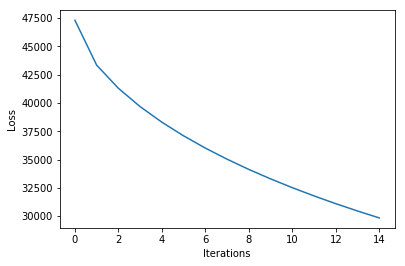

In [18]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.show()

#### Write the embeddings.

In [19]:
with open("{}_{}_{}_{}.center".format(filename, r, vector_dim, iterations), "w") as fd_center:
    for i in range(m):
        for j in range(vector_dim):
            fd_center.write("{} ".format(center_embedding[i][j]))
        # Write the bias weight.
        fd_center.write("{}\n".format(center_bias[i]))

In [20]:
with open("{}_{}_{}_{}.context".format(filename, r, vector_dim, iterations), "w") as fd_context:
    for i in range(m):
        for j in range(vector_dim):
            fd_context.write("{} ".format(context_embedding[i][j]))
        # Write the bias weight.
        fd_context.write("{}\n".format(context_bias[i]))